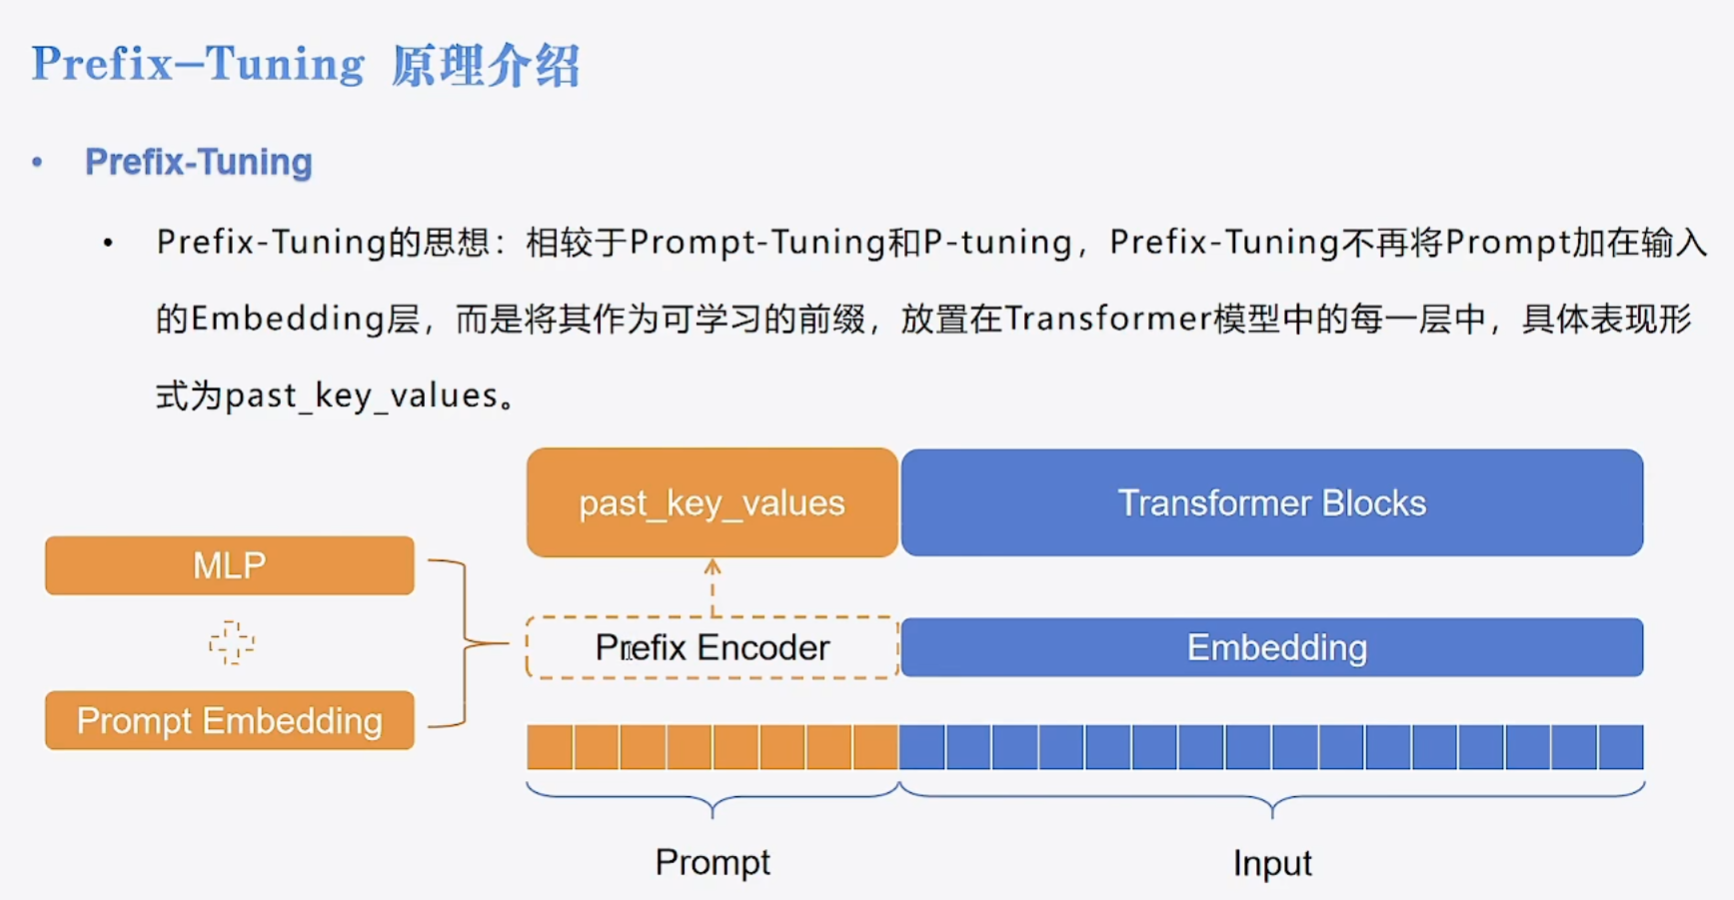

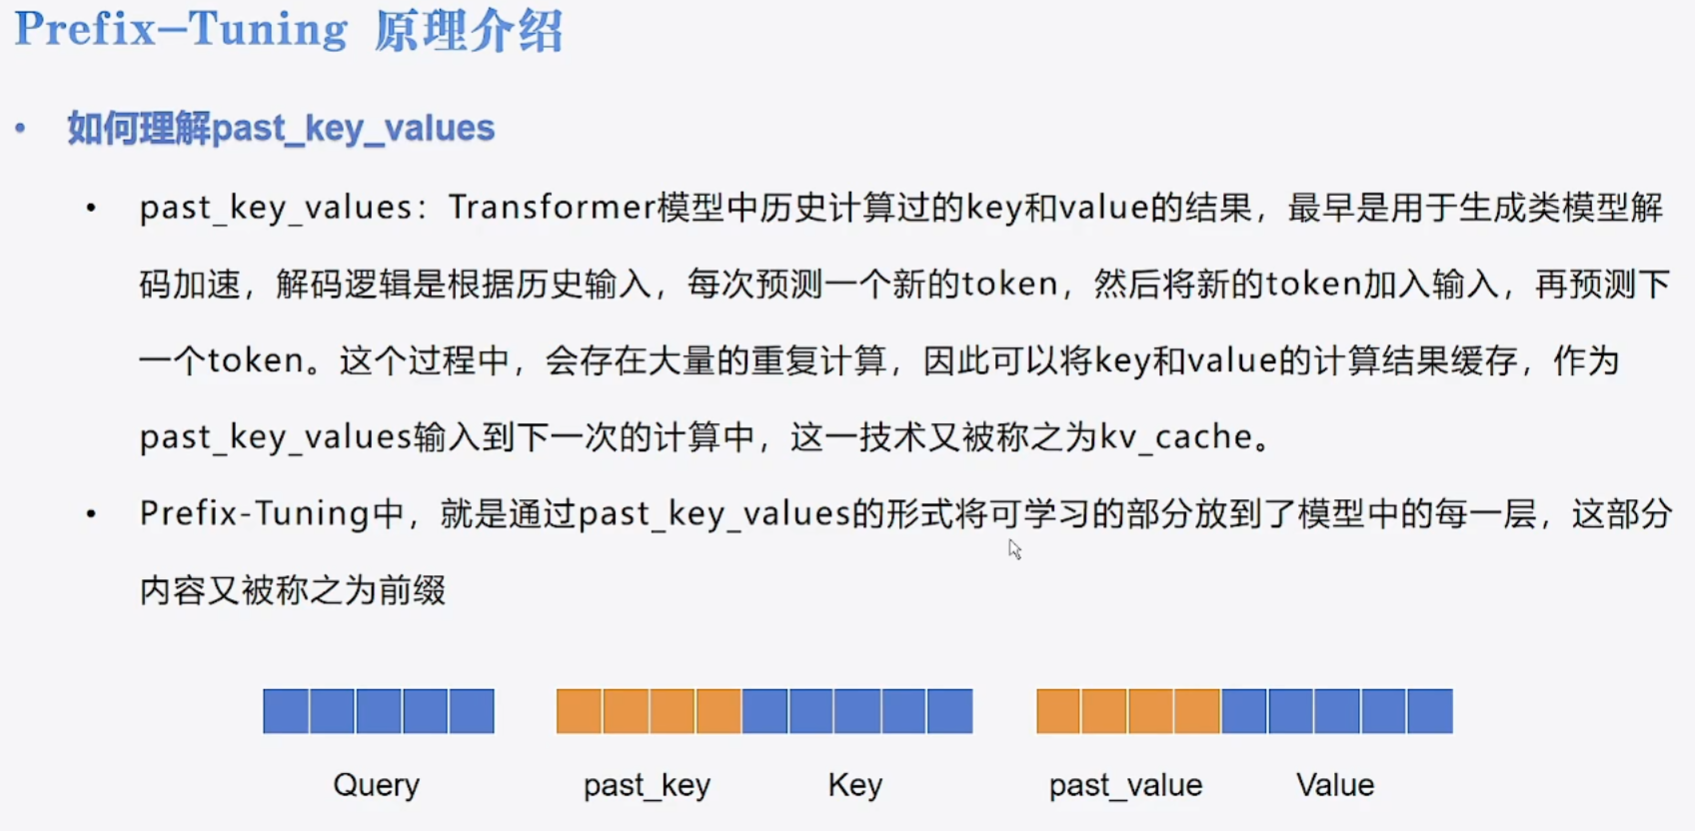

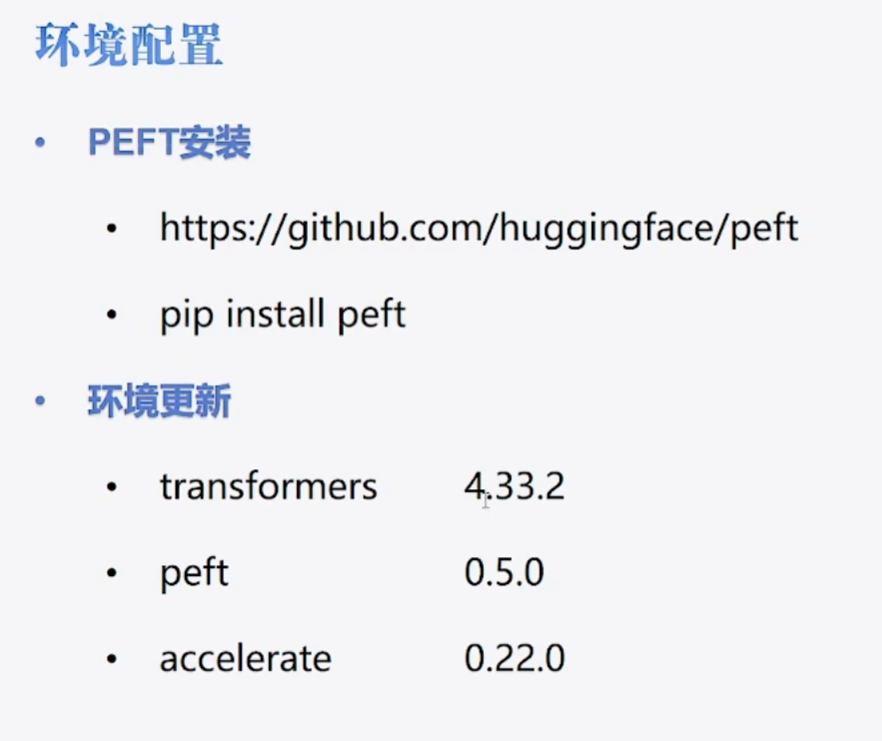

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [2]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [6]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True)

# Prefix-tuning

### Step1 配置文件

In [20]:
from peft import PrefixTuningConfig, TaskType, get_peft_model
# prefix_projection=False 默认为True，设置为False可以减少计算量,prefix_projection 通常是在配置提示学习的过程中会用到的一个布尔类型参数，常见于如 PrefixTuningConfig 这类配置类里。它决定了是否使用投影层（projection layer）来对前缀提示（prefix prompt）进行处理。
config = PrefixTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10,prefix_projection=True)
config

PrefixTuningConfig(peft_type=<PeftType.PREFIX_TUNING: 'PREFIX_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=10, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, encoder_hidden_size=None, prefix_projection=True)

### Step2 创建模型

In [21]:
model=get_peft_model(model,config)

In [22]:
model.print_trainable_parameters()

trainable params: 205,641,728 || all params: 1,508,753,408 || trainable%: 13.6299


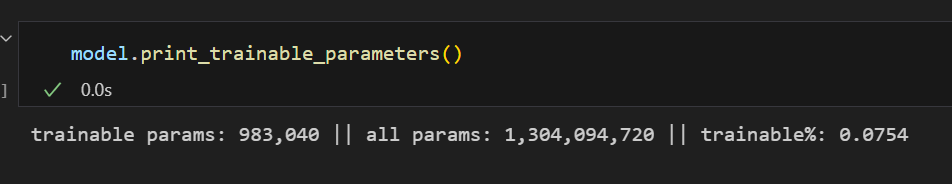prefix_projection=False

In [23]:
model.prompt_encoder

ModuleDict(
  (default): PrefixEncoder(
    (embedding): Embedding(10, 2048)
    (transform): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2048, out_features=98304, bias=True)
    )
  )
)

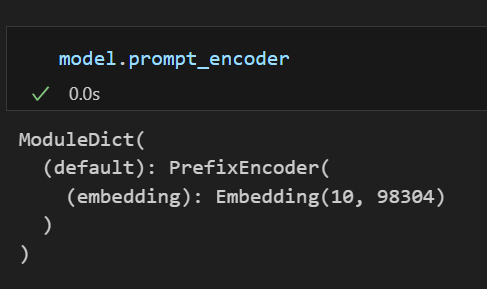  prefix_projection=False

------------

In [9]:
args = TrainingArguments(
    output_dir="./prefix-tuning",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [10]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

In [13]:
trainer.train()

  0%|          | 0/3357 [00:00<?, ?it/s]

{'loss': 5.8737, 'grad_norm': 0.6016741991043091, 'learning_rate': 4.985105749180816e-05, 'epoch': 0.0}
{'loss': 6.2666, 'grad_norm': 0.6763908863067627, 'learning_rate': 4.9702114983616324e-05, 'epoch': 0.01}
{'loss': 5.8753, 'grad_norm': 0.5410889983177185, 'learning_rate': 4.9553172475424484e-05, 'epoch': 0.01}
{'loss': 5.9124, 'grad_norm': 0.5827919244766235, 'learning_rate': 4.940422996723265e-05, 'epoch': 0.01}
{'loss': 5.8087, 'grad_norm': 0.6071367263793945, 'learning_rate': 4.925528745904081e-05, 'epoch': 0.01}
{'loss': 5.8953, 'grad_norm': 0.5524474382400513, 'learning_rate': 4.910634495084897e-05, 'epoch': 0.02}
{'loss': 5.6275, 'grad_norm': 0.5694793462753296, 'learning_rate': 4.895740244265713e-05, 'epoch': 0.02}
{'loss': 5.6263, 'grad_norm': 0.46630388498306274, 'learning_rate': 4.88084599344653e-05, 'epoch': 0.02}
{'loss': 5.675, 'grad_norm': 0.7115404009819031, 'learning_rate': 4.865951742627346e-05, 'epoch': 0.03}
{'loss': 5.4586, 'grad_norm': 0.4542524218559265, 'lear

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 4.0214, 'grad_norm': 0.3146817982196808, 'learning_rate': 4.240393208221627e-05, 'epoch': 0.15}
{'loss': 4.1378, 'grad_norm': 0.24641680717468262, 'learning_rate': 4.225498957402443e-05, 'epoch': 0.15}
{'loss': 4.0967, 'grad_norm': 0.27455490827560425, 'learning_rate': 4.2106047065832595e-05, 'epoch': 0.16}
{'loss': 4.004, 'grad_norm': 0.3073873221874237, 'learning_rate': 4.1957104557640756e-05, 'epoch': 0.16}
{'loss': 4.0688, 'grad_norm': 0.3359260857105255, 'learning_rate': 4.180816204944891e-05, 'epoch': 0.16}
{'loss': 4.0116, 'grad_norm': 0.2881861925125122, 'learning_rate': 4.165921954125708e-05, 'epoch': 0.17}
{'loss': 4.0292, 'grad_norm': 0.4000800549983978, 'learning_rate': 4.151027703306524e-05, 'epoch': 0.17}
{'loss': 4.1607, 'grad_norm': 0.2740205228328705, 'learning_rate': 4.1361334524873405e-05, 'epoch': 0.17}
{'loss': 3.9212, 'grad_norm': 0.23198889195919037, 'learning_rate': 4.121239201668156e-05, 'epoch': 0.18}
{'loss': 3.8136, 'grad_norm': 0.26601776480674744,

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 3.6213, 'grad_norm': 0.1792408525943756, 'learning_rate': 3.495680667262437e-05, 'epoch': 0.3}
{'loss': 3.5621, 'grad_norm': 0.1549815833568573, 'learning_rate': 3.480786416443253e-05, 'epoch': 0.3}
{'loss': 3.6893, 'grad_norm': 0.17455554008483887, 'learning_rate': 3.465892165624069e-05, 'epoch': 0.31}
{'loss': 3.6827, 'grad_norm': 0.20149874687194824, 'learning_rate': 3.450997914804885e-05, 'epoch': 0.31}
{'loss': 3.4844, 'grad_norm': 0.18094699084758759, 'learning_rate': 3.436103663985702e-05, 'epoch': 0.31}
{'loss': 3.6028, 'grad_norm': 0.1791633814573288, 'learning_rate': 3.421209413166518e-05, 'epoch': 0.32}
{'loss': 3.5261, 'grad_norm': 0.21690897643566132, 'learning_rate': 3.406315162347334e-05, 'epoch': 0.32}
{'loss': 3.7616, 'grad_norm': 0.2028471827507019, 'learning_rate': 3.39142091152815e-05, 'epoch': 0.32}
{'loss': 3.4627, 'grad_norm': 0.25174686312675476, 'learning_rate': 3.376526660708966e-05, 'epoch': 0.32}
{'loss': 3.4422, 'grad_norm': 0.18580445647239685, 'l

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 3.4507, 'grad_norm': 0.13770738244056702, 'learning_rate': 2.750968126303247e-05, 'epoch': 0.45}
{'loss': 3.4376, 'grad_norm': 0.14455845952033997, 'learning_rate': 2.7360738754840632e-05, 'epoch': 0.45}
{'loss': 3.5373, 'grad_norm': 0.14178650081157684, 'learning_rate': 2.7211796246648796e-05, 'epoch': 0.46}
{'loss': 3.4887, 'grad_norm': 0.16992147266864777, 'learning_rate': 2.7062853738456957e-05, 'epoch': 0.46}
{'loss': 3.5756, 'grad_norm': 0.18151149153709412, 'learning_rate': 2.691391123026512e-05, 'epoch': 0.46}
{'loss': 3.4577, 'grad_norm': 0.10241043567657471, 'learning_rate': 2.676496872207328e-05, 'epoch': 0.46}
{'loss': 3.3611, 'grad_norm': 0.1657276451587677, 'learning_rate': 2.6616026213881445e-05, 'epoch': 0.47}
{'loss': 3.1989, 'grad_norm': 0.11033066362142563, 'learning_rate': 2.6467083705689606e-05, 'epoch': 0.47}
{'loss': 3.3158, 'grad_norm': 0.1495826691389084, 'learning_rate': 2.631814119749777e-05, 'epoch': 0.47}
{'loss': 3.4402, 'grad_norm': 0.13758760690

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 3.3247, 'grad_norm': 0.20508942008018494, 'learning_rate': 2.0062555853440572e-05, 'epoch': 0.6}
{'loss': 3.221, 'grad_norm': 0.16745944321155548, 'learning_rate': 1.9913613345248736e-05, 'epoch': 0.6}
{'loss': 3.3539, 'grad_norm': 0.14211520552635193, 'learning_rate': 1.9764670837056897e-05, 'epoch': 0.6}
{'loss': 3.3046, 'grad_norm': 0.19610486924648285, 'learning_rate': 1.961572832886506e-05, 'epoch': 0.61}
{'loss': 3.4014, 'grad_norm': 0.12775693833827972, 'learning_rate': 1.946678582067322e-05, 'epoch': 0.61}
{'loss': 3.2711, 'grad_norm': 0.12259289622306824, 'learning_rate': 1.9317843312481382e-05, 'epoch': 0.61}
{'loss': 3.2034, 'grad_norm': 0.13503453135490417, 'learning_rate': 1.9168900804289542e-05, 'epoch': 0.62}
{'loss': 3.2718, 'grad_norm': 0.179640993475914, 'learning_rate': 1.9019958296097706e-05, 'epoch': 0.62}
{'loss': 3.2275, 'grad_norm': 0.185320183634758, 'learning_rate': 1.8871015787905867e-05, 'epoch': 0.62}
{'loss': 3.3015, 'grad_norm': 0.129544198513031

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 3.285, 'grad_norm': 0.2352188229560852, 'learning_rate': 1.2615430443848674e-05, 'epoch': 0.75}
{'loss': 3.389, 'grad_norm': 0.3425773084163666, 'learning_rate': 1.2466487935656837e-05, 'epoch': 0.75}
{'loss': 3.319, 'grad_norm': 0.17918099462985992, 'learning_rate': 1.2317545427464999e-05, 'epoch': 0.75}
{'loss': 3.349, 'grad_norm': 0.13330306112766266, 'learning_rate': 1.2168602919273161e-05, 'epoch': 0.76}
{'loss': 3.3253, 'grad_norm': 0.10749103128910065, 'learning_rate': 1.2019660411081324e-05, 'epoch': 0.76}
{'loss': 3.2857, 'grad_norm': 0.10499066859483719, 'learning_rate': 1.1870717902889484e-05, 'epoch': 0.76}
{'loss': 3.1841, 'grad_norm': 0.30396226048469543, 'learning_rate': 1.1721775394697646e-05, 'epoch': 0.77}
{'loss': 3.3783, 'grad_norm': 0.1313461810350418, 'learning_rate': 1.1572832886505809e-05, 'epoch': 0.77}
{'loss': 3.4115, 'grad_norm': 0.23697838187217712, 'learning_rate': 1.1423890378313971e-05, 'epoch': 0.77}
{'loss': 3.3042, 'grad_norm': 0.212401166558

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 3.1989, 'grad_norm': 0.13790951669216156, 'learning_rate': 5.168305034256777e-06, 'epoch': 0.9}
{'loss': 3.3184, 'grad_norm': 0.2137533277273178, 'learning_rate': 5.019362526064939e-06, 'epoch': 0.9}
{'loss': 3.3396, 'grad_norm': 0.16365770995616913, 'learning_rate': 4.870420017873101e-06, 'epoch': 0.9}
{'loss': 3.1507, 'grad_norm': 0.1322053074836731, 'learning_rate': 4.721477509681263e-06, 'epoch': 0.91}
{'loss': 3.2787, 'grad_norm': 0.13549846410751343, 'learning_rate': 4.572535001489425e-06, 'epoch': 0.91}
{'loss': 3.2931, 'grad_norm': 0.12527421116828918, 'learning_rate': 4.423592493297587e-06, 'epoch': 0.91}
{'loss': 3.3903, 'grad_norm': 0.11338315904140472, 'learning_rate': 4.274649985105749e-06, 'epoch': 0.91}
{'loss': 3.2988, 'grad_norm': 0.11652734875679016, 'learning_rate': 4.125707476913911e-06, 'epoch': 0.92}
{'loss': 3.3904, 'grad_norm': 0.164415180683136, 'learning_rate': 3.976764968722073e-06, 'epoch': 0.92}
{'loss': 3.2181, 'grad_norm': 0.12005829066038132, 'l

TrainOutput(global_step=3357, training_loss=3.65769881224895, metrics={'train_runtime': 2720.7864, 'train_samples_per_second': 9.871, 'train_steps_per_second': 1.234, 'total_flos': 1.476411489067008e+16, 'train_loss': 3.65769881224895, 'epoch': 0.9999255342914588})

In [14]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 考试有哪些技巧？
在考试时，除了注意以下事项，在心理状态上，不要太紧张太紧张。
首先，应避免被焦虑感所纠缠。在考试前，不要太紧张太紧张。但一定要做好心理准备。
其次，要注意放松。放松是保持良好心态的关键要素，并且，放松也是增强压力的关键要素。在考试过程中，要做好心理准备。同时，在心理上保持放松可以让自己更加平静。在心理上保持放松可以有利于保持最佳心理状态。在心理上保持放松还可以维持


In [17]:
from peft import PeftModel
peft_model = PeftModel.from_pretrained(model, "./prefix-tuning/checkpoint-500")
peft_model  

PeftModelForCausalLM(
  (base_model): PeftModelForCausalLM(
    (base_model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(46145, 2048)
        (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (mlp): BloomMLP(
              (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
              (gelu_impl): BloomGelu()
              (dense_4h_to_h): Linear(in_fe

In [18]:
peft_model = peft_model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 免得
Comment: 免得
Comment: 免得
Comment: 免得
Comment: 免得
